In [1]:
import sys
print(sys.executable)

/anaconda3/envs/magpie/bin/python


## Deep Learning with Keras - Google Analytics Customer Revenue Prediction


### Dependencies

In [2]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

Using TensorFlow backend.


### Helper Functions

In [3]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df


def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

### The load_df function is borrowed from this [kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook)

In [4]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df

In [5]:
train = load_df("train.csv")
test = load_df("test.csv")

### Closer look at the Training Data

In [6]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,go

### Generating a Training Set and a Testing Set 

In [8]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 50
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flashVersion' 'isMobile'
 'language' 'mobileDeviceBranding' 'mobileDeviceInfo'
 'mobileDeviceMarketingName' 'mobileDeviceModel' 'mobileInputSelector'
 'operatingSystem' 'operatingSystemVersion' 'screenColors'
 'screenResolution' 'city' 'cityId' 'continent' 'country' 'latitude'
 'longitude' 'metro' 'networkDomain' 'networkLocation' 'region'
 'subContinent' 'bounces' 'hits' 'newVisits' 'pageviews'
 'transactionRevenue' 'visits' 'adContent' 'adwordsClickInfo' 'campaign'
 'campaignCode' 'isTrueDirect' 'keyword' 'medium' 'referralPath' 'source']

TEST SET
Rows: 804684
Columns: 48
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flash

### Performing Feature Engineering

In [9]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')
train['hits'] = train['hits'].astype(float)
test['hits'] = test['hits'].astype(float)
train['pageviews'] = train['pageviews'].astype(float)
test['pageviews'] = test['pageviews'].astype(float)

In [10]:
train

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,year,month,day,weekday
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1.0,1,1.0,

### Agregated features

In [11]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

### Exploratory data analysis

## Let's take a look at our target value through the time.

In [12]:
time_agg = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['transactionRevenue'].agg(['count','sum'])

## Here is sum of our tagert feature "transactionRevenue" through the time.

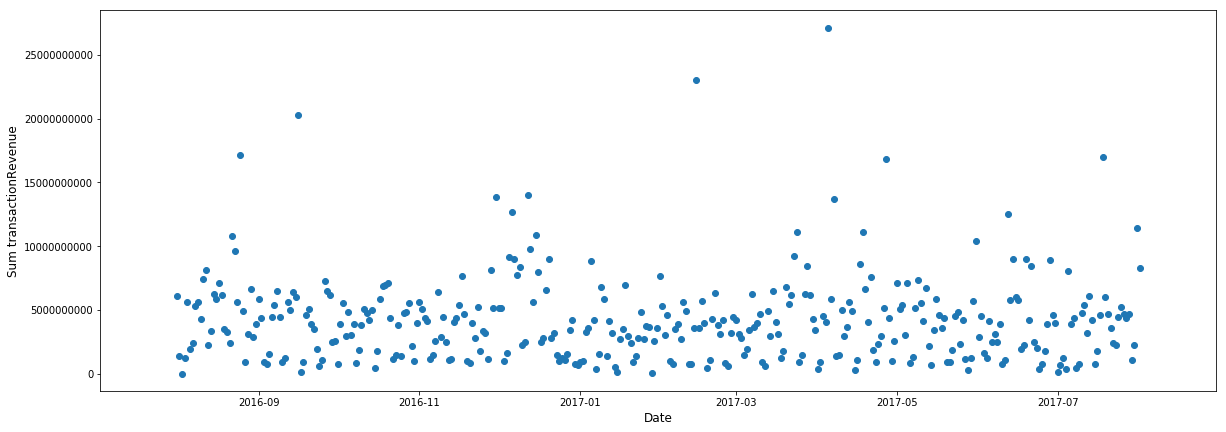

In [13]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

## Seems like we had more transactions in the late 2016 than early 2017. Date seems to be an important feature

## The Count for our Target Attribute "transactionRevenue" through its frequency.

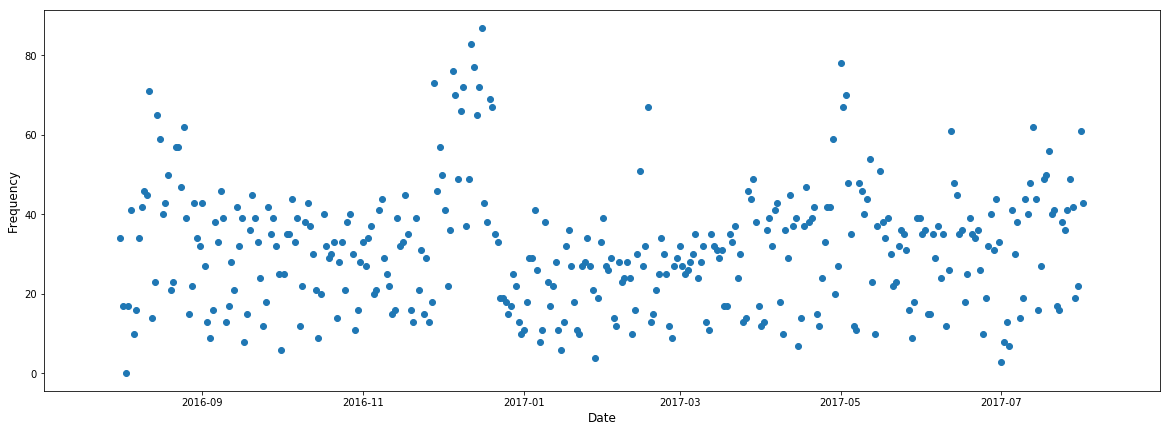

In [14]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

## There is a spike in frequency observed duiring the time frame of late 2016. 

## Let us take a look at other time features, namely Year, Month, Day and Weekday

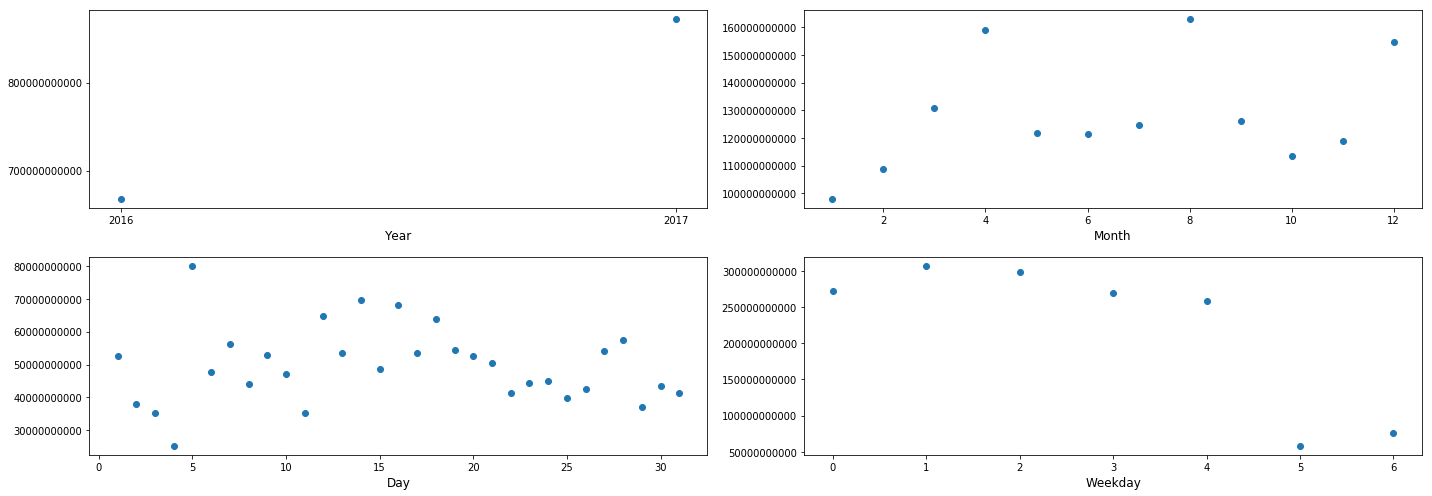

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

### About the engineered time features
* Year: It seem transactions had a large increase from 2016 to 2017
* Month: Lager transactions in december seems to be alright, considering the holiday seasons, but I am not entirely sure why april and august have higher transactions. 
* Day: There seems to be nothing peculiar going on
* Weekday: Curious result, people seem to perform less transactions on weekends than weekdays

### Cleaning the data 

In [20]:
train


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,year,month,day,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1.0,1,1.0,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google,2016,9,2,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not availab

In [22]:
#dropping the dictionary column
train = train.drop(['adwordsClickInfo'], axis=1)
test = test.drop(['adwordsClickInfo'], axis=1)

KeyError: "['adwordsClickInfo'] not found in axis"

In [23]:
# Drop column that exists only in train data
train = train.drop(['campaignCode'], axis=1)
# Input missing transactionRevenue values
train["transactionRevenue"].fillna(0, inplace=True)


In [24]:
# dropiing the unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 
                    'browser', 'browserSize', 'browserVersion', 'flashVersion', 
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign', 
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 'day']

In [25]:
train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)

In [26]:
train


,channelGrouping,date,socialEngagementType,visitNumber,deviceCategory,isMobile,language,mobileDeviceBranding,screenResolution,city,cityId,continent,country,latitude,longitude,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,medium,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,Izmir,Western Asia,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,Australasia,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,Community of Madrid,Southern Europe,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2016-09-02,Not Socially Engaged,2,mobile,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,Northern Europe,1,1.0,NaN,1.0,0.0,1,organic,2016,9,4,4.324027,3.666491,90290.0,76560.0
477847,Organic Search,2016-08-10,Not Socially Engaged,1,mobile,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,Northern Europe,1,1.0,1,1.0,0.0,1,organic,2016,8,2,4.324027,3.666491,90290.0,76560.0
5,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,Southern Europe,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
6,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,Southern Asia,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
7,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,Brisbane,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,Queensland,Australasia,1,1.0,1,1.0,0.0,1,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
8,Organic Search,2016-09-02,Not Socially Engaged,1,desktop,False,not available in demo dataset,not available in dem

In [27]:
# columns with constant values

# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)

Columns with constant values:  ['socialEngagementType', 'language', 'mobileDeviceBranding', 'screenResolution', 'cityId', 'latitude', 'longitude', 'bounces', 'newVisits', 'visits']


In [28]:
# cleaning constant columns 

train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)

In [30]:
# columns with more than 50
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns with null values are: ', high_null_columns)

Columns with null values are:  []


In [31]:
## NO Columns have more than 50% Null Values 


In [33]:
train

,channelGrouping,date,visitNumber,deviceCategory,isMobile,city,continent,country,region,subContinent,hits,pageviews,transactionRevenue,medium,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1,desktop,False,Izmir,Asia,Turkey,Izmir,Western Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Oceania,Australia,not available in demo dataset,Australasia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,1,desktop,False,Madrid,Europe,Spain,Community of Madrid,Southern Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Asia,Indonesia,not available in demo dataset,Southeast Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2016-09-02,2,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,organic,2016,9,4,4.324027,3.666491,90290.0,76560.0
477847,Organic Search,2016-08-10,1,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,organic,2016,8,2,4.324027,3.666491,90290.0,76560.0
5,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Europe,Italy,not available in demo dataset,Southern Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
6,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Asia,Pakistan,not available in demo dataset,Southern Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
7,Organic Search,2016-09-02,1,desktop,False,Brisbane,Oceania,Australia,Queensland,Australasia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
8,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Europe,Austria,not available in demo dataset,Western Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0


In [34]:
# Training dataset
#rows
train.shape[0]

903653

In [35]:
#columns
train.shape[1]

21

In [38]:
# features
train.columns.values

array(['channelGrouping', 'date', 'visitNumber', 'deviceCategory',
       'isMobile', 'city', 'continent', 'country', 'region',
       'subContinent', 'hits', 'pageviews', 'transactionRevenue',
       'medium', 'year', 'month', 'weekday', 'mean_hits_per_day',
       'mean_pageviews_per_day', 'sum_hits_per_day',
       'sum_pageviews_per_day'], dtype=object)

In [39]:
# Testing Dataset
# rows
test.shape[0]

804684

In [40]:
#columns
test.shape[1]

20

In [41]:
test.columns.values

array(['channelGrouping', 'date', 'visitNumber', 'deviceCategory',
       'isMobile', 'city', 'continent', 'country', 'region',
       'subContinent', 'hits', 'pageviews', 'medium', 'year', 'month',
       'weekday', 'mean_hits_per_day', 'mean_pageviews_per_day',
       'sum_hits_per_day', 'sum_pageviews_per_day'], dtype=object)

In [43]:
train.head()

,channelGrouping,date,visitNumber,deviceCategory,isMobile,city,continent,country,region,subContinent,hits,pageviews,transactionRevenue,medium,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1,desktop,False,Izmir,Asia,Turkey,Izmir,Western Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Oceania,Australia,not available in demo dataset,Australasia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,2016-09-02,1,desktop,False,Madrid,Europe,Spain,Community of Madrid,Southern Europe,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,2016-09-02,1,desktop,False,not available in demo dataset,Asia,Indonesia,not available in demo dataset,Southeast Asia,1.0,1.0,0.0,organic,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2016-09-02,2,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,organic,2016,9,4,4.324027,3.666491,90290.0,76560.0
